# Import libiraires

In [1]:
import os

import cv2
import imutils
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split

# Show the figures / plots inside the notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Download utils file

In [3]:
ROOT = os.getcwd()

ROOT = os.path.dirname(ROOT)

In [4]:
def show_images(images, titles=None):
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [6]:
from kaggle import KaggleApi

dataset_dir = './car-plate-detection'
if not os.path.exists(dataset_dir):
    # Authenticate
    api = KaggleApi()
    api.authenticate()

    # Download the dataset
    api.dataset_download_files('andrewmvd/car-plate-detection', path=dataset_dir, unzip=True)

dataset_dir = './characters-and-digits-for-classification'
if not os.path.exists(dataset_dir):
    # Authenticate
    api = KaggleApi()
    api.authenticate()

    # Download the dataset
    api.dataset_download_files('loayhassanali/characters-and-digits-for-classification', path=dataset_dir, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/loayhassanali/characters-and-digits-for-classification


# Preprocessing

### function to load images and it labels

In [7]:
def load_image_and_annotation_from_txt(txt_file, image_dir):
    image_annotation_pairs = []

    with open(txt_file, 'r') as file:
        lines = file.readlines()

        for line in lines:
            parts = line.strip().split(',')

            if len(parts) != 2 or not parts[1].isalnum():
                continue

            image_name, annotation = parts

            image_path = os.path.join(image_dir, image_name)

            if not os.path.exists(image_path):
                print(f"Warning: Image {image_name} not found in {image_dir}. Skipping.")
                continue

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            image_annotation_pairs.append((image, annotation))

    return image_annotation_pairs


In [9]:
# load image
annotation = './characters-and-digits-for-classification/annotation.txt'
image_dir = './characters-and-digits-for-classification/images'
image_annotation = load_image_and_annotation_from_txt(annotation, image_dir)

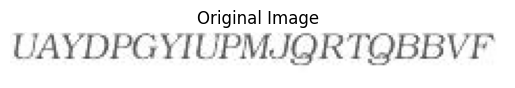

In [10]:
show_images([image_annotation[0][0]],
            ['Original Image'])

### Function to apply preprocessing to images

In [11]:
def apply_morphological_operations(image, kernel_size=3):
    structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

    # Apply morphological operations
    img_top_hat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, structuring_element)
    img_black_hat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, structuring_element)

    img_grayscale_plus_top_hat = cv2.add(image, img_top_hat)
    image = cv2.subtract(img_grayscale_plus_top_hat, img_black_hat)

    return image

In [12]:
def convert_to_gray(image):
    if len(image.shape) == 2:
        return image

    height, width, channels = image.shape
    gray_image = image
    if channels == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    elif channels == 4:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
    else:
        print("Unknown color system the image will remain unchanged")

    return gray_image

In [13]:
def process_images(image):
    # convert to gray scale
    gray_scale_image = convert_to_gray(image)
    gray_filter = cv2.bilateralFilter(gray_scale_image, 13, 15, 15)

    gray_filter = apply_morphological_operations(gray_filter)

    binary_image_adaptive = cv2.adaptiveThreshold(
        gray_filter, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        19,
        9)
    return binary_image_adaptive


### Function to find contours of plate numbers

In [14]:
def preprocess_image(image_path, image=None):
    # load image
    if image is None:
        image = cv2.imread(image_path)
        original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        original_image = image

    # convert to gray scale
    gray_scale_image = convert_to_gray(original_image)
    # apply bilateral filter
    gray_filter = cv2.bilateralFilter(gray_scale_image, 13, 15, 15)

    gray_filter = apply_morphological_operations(gray_filter)

    binary_image_adaptive = cv2.adaptiveThreshold(
        gray_filter, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        19,
        9)

    return binary_image_adaptive


def find_contours(image):
    edged = np.uint8(image)  # Convert to an uint8 type

    # retrieves all the contours without establishing any hierarchical relationships.
    contours = cv2.findContours(edged.copy(),
                                cv2.RETR_LIST,
                                cv2.CHAIN_APPROX_SIMPLE)

    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    x_similarity_threshold = 10  # the threshold in x-axis to say that two contours have the same x coordinate
    y_similarity_threshold = 10  # the threshold in y-axis to say that two contours have the same x coordinate

    best_contours = []

    for contour in contours:
        # bounding rectangle returns the x,y of the top left corner and the width and height of the rect.
        x, y, w, h = cv2.boundingRect(contour)

        # Apply size and aspect ratio filters
        if 30 < w * h < 1500 and 4 > h / w > 1 and h > 10:
            is_duplicate = False

            # Check if the contour is duplicate
            for existing_x, existing_y, _, _ in best_contours:
                if (abs(x - existing_x) < x_similarity_threshold and
                        abs(y - existing_y) < y_similarity_threshold):
                    is_duplicate = True
                    break

            if not is_duplicate:
                best_contours.append([x, y, w, h])

    return best_contours


def get_y_coordinate(contour):
    _, y, _, _ = contour
    return y


def get_x_coordinate(contour):
    x, _, _, _ = contour
    return x


# Function to get the contours with common height as the plate numbers will be probably
# with the same height for the same car,
# so we can remove other contours which they will be not relevant
def get_common_contours_height(groups):
    tolerance = 20

    for i in range(len(groups)):
        group = groups[i]

        height = [h for _, _, w, h in group]

        # Determine the median area
        median_height = np.median(height)

        lower_bound = median_height - median_height * (tolerance / 100)
        upper_bound = median_height + median_height * (tolerance / 100)

        filtered_group = []
        for contour in group:
            height = contour[3]
            if lower_bound <= height <= upper_bound:
                filtered_group.append(contour)

        # Update the group with filtered contours
        groups[i] = filtered_group

    return groups


# Divide the contours to groups based on y-axis level
def divide_contours_to_groups_vertically(contours):
    # Sort the contours based on the y-coordinate
    sorted_contours = sorted(contours, key=get_y_coordinate)

    contours_group = [[]]
    group_idx = 0
    vertical_threshold = 15  # define the maximum vertical difference between two contours

    for i in range(len(sorted_contours)):
        if len(contours_group[group_idx]) == 0:
            contours_group[group_idx].append(sorted_contours[i])
            continue

        current_contour = sorted_contours[i]
        first_contour = contours_group[group_idx][0]

        current_y = current_contour[1]
        first_y = first_contour[1]

        vertical_check = current_y < first_y + vertical_threshold

        if vertical_check:
            contours_group[group_idx].append(sorted_contours[i])
        else:
            group_idx += 1
            contours_group.append([sorted_contours[i]])

    return contours_group


def get_horizontal_groups(sorted_horizontal_contours):
    groups = [[]]
    group_idx = 0
    overlap_threshold = 10
    horizontal_threshold = 30  # define the maximum horizontal difference between two contours
    for i in range(len(sorted_horizontal_contours)):

        if len(groups[group_idx]) == 0:
            groups[group_idx].append(sorted_horizontal_contours[i])
            continue

        current_x, _, current_w, _ = sorted_horizontal_contours[i]
        last_x, _, last_w, _ = groups[group_idx][-1]

        right_horizontal_check = (
                last_x + last_w + horizontal_threshold > current_x > last_x + last_w - overlap_threshold)

        if right_horizontal_check:
            groups[group_idx].append(sorted_horizontal_contours[i])
        else:
            group_idx += 1
            groups.append([sorted_horizontal_contours[i]])
    return groups


def divide_contours_to_groups_horizontally(contours_group):
    horizontal_groups = []
    for group in contours_group:
        if len(group) < 4:
            continue

        sorted_group = sorted(group, key=get_x_coordinate)
        horizontal_groups = horizontal_groups + get_horizontal_groups(sorted_group)

    return horizontal_groups


def find_plate_chars(image):
    # If you pass cv.CHAIN_APPROX_NONE,
    # all the boundary points are stored.
    # But actually do we need all the points?
    # For e.g., you found the contour of a straight line.
    # Do you need all the points on the line to represent that line?
    # No, we need just two end points of that line.
    # This is what cv.CHAIN_APPROX_SIMPLE does.
    # It removes all redundant points and compresses the contour,
    # thereby saving memory.
    best_groups = []  # list to store the best groups of contours that represent the characters of the plate

    best_contours = find_contours(image)

    # Divide the contours to groups based on y-axis level
    contours_group = divide_contours_to_groups_vertically(best_contours)

    # Divide the contours to groups based on x-axis level
    horizontal_groups = divide_contours_to_groups_horizontally(contours_group)

    horizontal_groups = get_common_contours_height(horizontal_groups)
    # ---------------------------------Grab the sequences lager than 4 contours--------------------------------
    for group in horizontal_groups:
        if len(group) < 4:
            continue
        best_groups.append(group)

    return best_groups


def get_chars_from_contours(contour, image):
    x, y, w, h = contour
    char = image[y:y + h, x:x + w]
    char = cv2.resize(char, (28, 28))
    char = apply_morphological_operations(char)
    binary_image_adaptive = cv2.adaptiveThreshold(
        char, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        31,
        5)
    return binary_image_adaptive


## Function to generate dataset

In [15]:
# Function to generate the data set  by utilizing the process image function and our function that get contours 
# after getting the contours be checked if the number of contours is the same as the number of characters of the plate
# if this condition holds we take this image and split it to chacracters using the contours we got then we assgin the correct
# label to the cropped character
def generate_dataset(image_annotation):
    images = []
    labels = []
    for image, anno in image_annotation:
        processed_image = process_images(image)
        groups = find_plate_chars(processed_image)
        if len(groups) != 1:
            continue
        group = groups[0]
        chars = list(anno)
        if len(group) != len(chars):
            continue

        idx = 0
        for contour in group:
            char = get_chars_from_contours(contour, processed_image)
            images.append(char)
            labels.append(chars[idx])
            idx += 1

    return images, labels

In [16]:
dataset_images, dataset_labels = generate_dataset(image_annotation)

In [17]:
dataset_images = np.array(dataset_images)
dataset_labels = np.array(dataset_labels)

In [18]:
len(dataset_images), len(dataset_labels)

(60312, 60312)

### function to extract features from images

In [19]:
# Now you can resize each image in the dataset
def extract_features(dataset_images):
    features = []
    for img in dataset_images:
        if img is None:
            print("Warning: Skipping None image")
            continue
        img_resized = cv2.resize(img, (28, 28))
        img_flattened = img_resized.flatten()
        features.append(img_flattened)
    return features

In [20]:
features = extract_features(dataset_images)

# Training the model

## Split the dataset

In [21]:
x_train, x_test, y_train, y_test = train_test_split(features, dataset_labels, test_size=0.2, random_state=42)

## Train the model using SVM

In [22]:
model = svm.SVC(kernel='rbf', random_state=42, C=1)
model.fit(x_train, y_train)
accuracy = model.score(x_test, y_test)

## Save the model

In [23]:
joblib.dump(model, f'OCR_SVM.pkl')
print('OCR_SVM', 'accuracy:', accuracy * 100, '%')

OCR_SVM accuracy: 99.6518279035066 %


In [24]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1100
           1       1.00      1.00      1.00      1103
           2       1.00      1.00      1.00      1161
           3       1.00      1.00      1.00      1182
           4       1.00      1.00      1.00      1129
           5       1.00      1.00      1.00      1122
           6       1.00      1.00      1.00      1134
           7       1.00      1.00      1.00      1117
           8       1.00      1.00      1.00      1133
           9       1.00      1.00      1.00      1109
           A       1.00      1.00      1.00        21
           B       1.00      0.97      0.98        31
           C       0.97      1.00      0.98        28
           D       0.97      0.97      0.97        30
           E       1.00      1.00      1.00        24
           F       1.00      1.00      1.00        36
           G       1.00      1.00      1.00        26
           H       1.00    

D:\Projects\CropsPredection\CropsAPI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Projects\CropsPredection\CropsAPI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Projects\CropsPredection\CropsAPI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

# Test the model

pred: 9


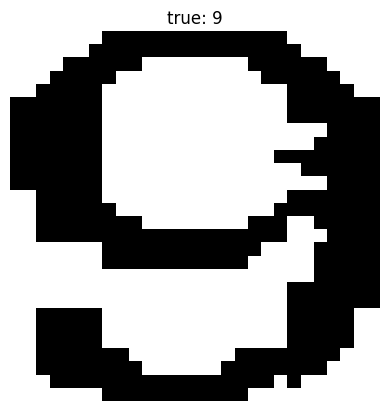

In [27]:
label = y_test[0]
prediction = model.predict([x_test[0]])[0]

print(f'pred: {prediction}')
show_images([x_test[0].reshape(28, 28)], [f'true: {y_test[0]}'])

In [29]:
DATA_DIR = 'car-plate-detection'  # Kaggle
IMAGES_DIR = os.path.join(DATA_DIR, 'images')
ANNOTATIONS_DIR = os.path.join(DATA_DIR, 'annotations')
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 200
image_files = sorted(os.listdir(IMAGES_DIR))

In [30]:
# Function to load an image and its corresponding annotation
def load_image(image_name, image_dir):
    image_path = os.path.join(image_dir, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

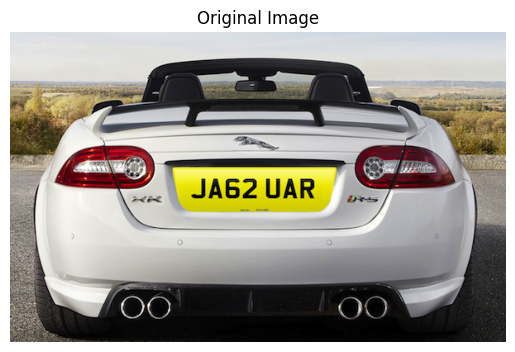

In [31]:
# load image
original_image = load_image(image_files[141], IMAGES_DIR)
show_images([original_image],
            ['Original Image'])

In [32]:
chars = []
processed_image = process_images(original_image)
groups = find_plate_chars(processed_image)
for group in groups:
    for contour in group:
        char = get_chars_from_contours(contour, processed_image)
        chars.append(char)

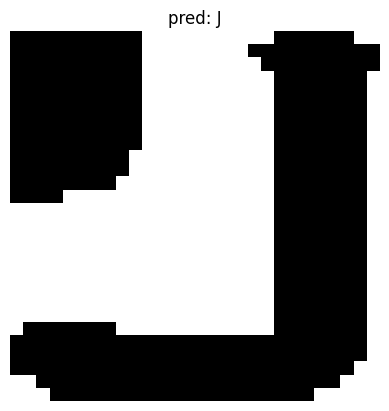

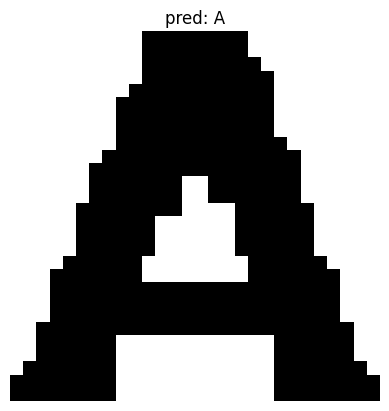

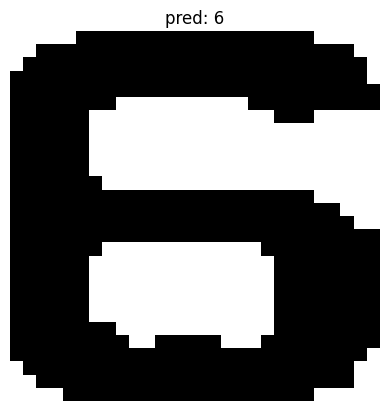

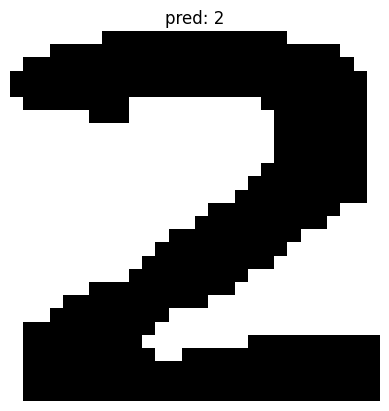

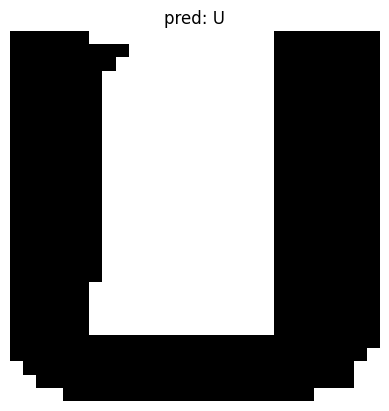

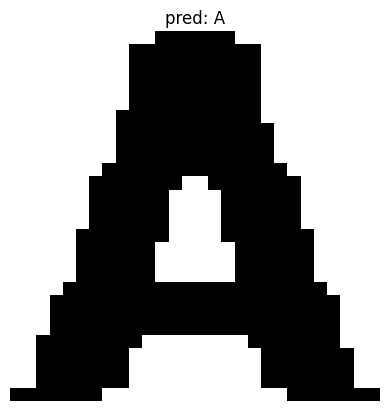

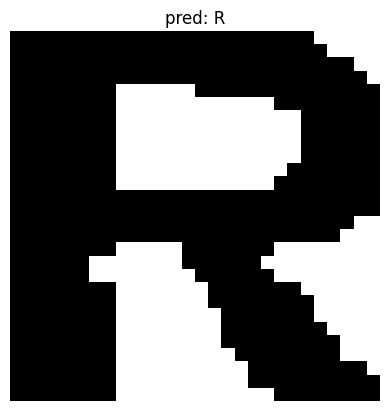

In [33]:
for char in chars:
    features = np.array(extract_features([char])).reshape(-1, 1).flatten()
    prediction = model.predict([features])[0]
    show_images([features.reshape(28, 28)], [f'pred: {prediction}'])